## Sobre este notebook de Jupyter

### Integración entre Python y C / CUDA

Estos notebooks ejecutan en general código de Python, pero también podemos utilizar comandos de la consola, escribir y modificar archivos entre otras tareas. Como vamos a trabajar simultaneamente con Python, C y CUDA, escribiremos los códigos en archivos .c y .cu actualizados por este notebook, compilaremos con GCC y NVCC enviando los comandos a la consola e integraremos la ejecución y el análisis con Python.

Podemos por ejemplo escribir una función en C que reciba como parámetros dos flotantes y la dirección de memoria de un tercero (para escribir el resultado).

In [0]:
# writefile genera un archivo en el directorio de trabajo actual
%%writefile test.c
void suma_numeros(float a, float b, float * c){
    *c = a + b;  // Suma a + b y guarda el resultado en c
}

Writing test.c


Compilamos mediante gcc, con las opciones **-fPIC** (Position Independent Code) y **-shared** (con linkeo dinámico). Estas dos opciones son fundamentales para poder ejecutar las funciones desde Python.

In [0]:
!gcc -Wall -fPIC -c test.c -o test_o.o
!gcc -shared test_o.o -o libtest.so
!ls

libtest.so  sample_data  test.c  test_o.o


Luego, desde Python, utilizamos la librería del siguiente modo:

In [0]:
from ctypes import CDLL, c_float, byref
clib = CDLL('./libtest.so')  # Carga la libreria

# Genera 3 flotantes de C (python usa por defecto el tipo double)
a = c_float(5.3)
b = c_float(2.2)
c = c_float(0.0)

# Llama a la función suma_numeros que hicimos 
clib.suma_numeros(a, b, byref(c))  # con byref pasa la dirección de c

# Verificamos el estado de c y vemos que la función lo modificó
print(c)

c_float(7.5)


### Google Colabarotory

Google Colaboratory es un notebook de Jupyter gratuito que se ejecuta en la nube y se almacena en el espacio de Google Drive. Los recursos que nos ofrece para ejecutar el código incluyen GPUs y TPUs (con tiempos y disponibilidad límitados). Nos permitirá por lo tanto hacer pruebas en CUDA sin utilizar nuestros recursos de computo ni depender de los mismos.

In [0]:
# Si nos conectamos correctamente a una pc con GPU veremos su información
# De lo contrario obtendremos un error de comunicación con el driver de NVIDIA
!nvidia-smi

Mon May 25 23:46:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Introducción

Queremos realizar la convolución entre un objeto (representado por una lista de posiciones en $\,\!R^2$ o $\,\!R^3\,$) y la PSF asociada al dispositivo de medición. La convolución entre el objeto y la PSF corresponderá entonces a reemplazar cada posición de la lista (fuente puntual) por la PSF (respuesta del dispositivo a un punto).

Vamos a considerar el caso donde la PSF esta dada por un conjunto de datos, al que llamaremos LUT (LookUp Table), ya sea porque la misma no puede ser representada por una función parametrizada o porque no resulta conveniente.

Reemplazar cada posición por una PSF del tipo LUT significa "pegar" los datos de las misma en cada posición. Nos surge entonces una incompatiblidad entre los sistemas de posiciones: la imagen y la LUT ocupan posición discretas (en principio con grillas diferentes), mientras que las fuentes se mueven en forma continua (tan continua como le permite la precisión de máquina).

Queremos evitar que las posiciones de las fuentes sean truncadas (o al menos reducir y controlar el efecto de hacerlo), y una forma de hacerlo es aumentar la información existente en la LUT (para poder pegarla en la posición requerida). Si los datos que componen nuestra PSF fueron calculados a partir de una parametrización podremos utilizar la misma para reducir el error de truncado (a costa de utilizar más memoria y tiempo de acceso a la misma). Si en cambio la parametrización no es una opción, deberemos recurrir a algún tipo de interpolado (y caracterizar el error cometido).

Debemos aclara que para PSFs parametrizadas ya desarrollamos rutinas de convolución en C (CPU) y CUDA (GPU). Evaluaremos el rendimiento entre ambos casos, ya que cualquier PSF parametrizada puede utilizarse para generar una PSF del tipo LUT.

### Ejemplo de convolución con PSF parametrizada

En el siguiente ejemplo utilizamos una PSF gaussiana calculada para cualquier posición (dominio real) mediante su expresión matemática. Todo el script se ejecuta en Python y no se utiliza la GPU.

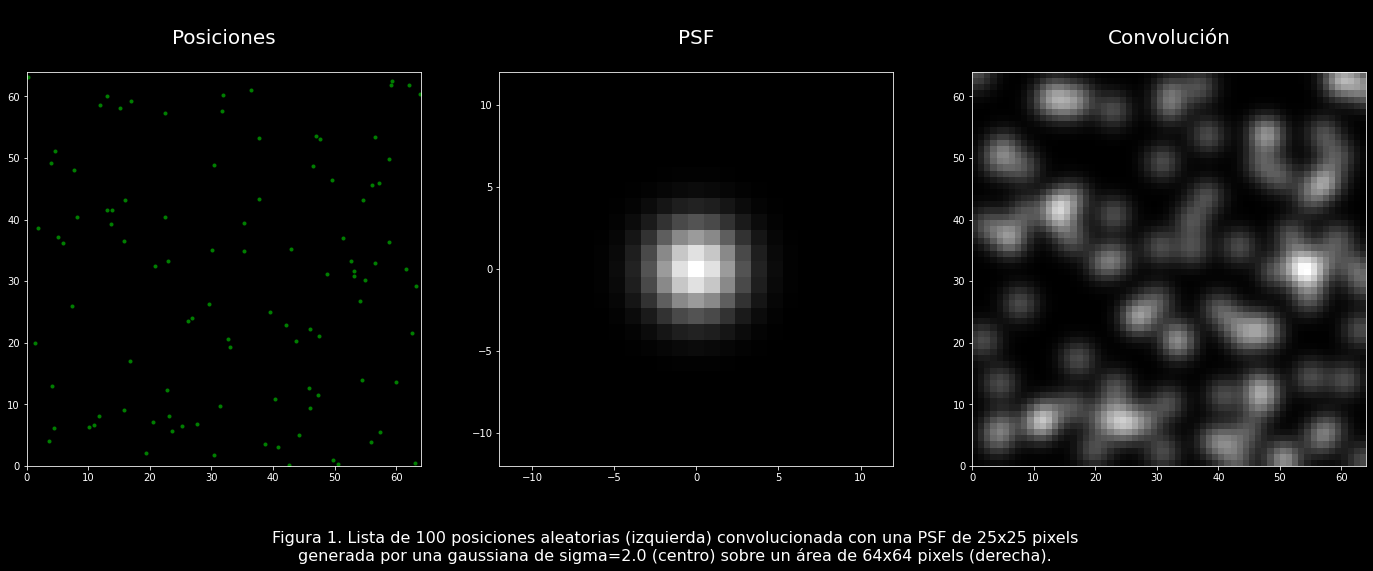

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Tamaño de la imagen convolucionada
convolution_size = [64, 64]
# Tamaño de la PSF
psf_size = (25, 25)
# Cantidad de fuentes
n_sources = 100
# Sigma de la PSF
sigma = 2.0

# Fuentes
sources = np.random.rand(n_sources, 2) * convolution_size

# Sistema de coordenadas de la imagen (con origen en una esquina)
x, y = np.mgrid[0:convolution_size[0], 0:convolution_size[1]]
# Sistema de coordenadas de la PSF (con origen en el centro)
x_psf, y_psf = np.mgrid[0:psf_size[0], 0:psf_size[1]]
x_psf -= int(psf_size[0] // 2)
y_psf -= int(psf_size[1] // 2)

# PSF evaluada en el espacio asignado
psf = np.exp(-(x_psf**2 + y_psf**2) / sigma**2 / 2)

# Imagen de convolución en blanco
image = np.zeros(convolution_size[::-1])
# Para cada punto en la lista de fuentes
for point in sources:
    px, py = point
    # Calcula la PSF para el desplazamiento decimal dado
    displaced_psf = np.exp(-((x-px)**2 + (y-py)**2) / sigma**2 / 2)
    # Suma la contribución de la PSF en la imagen
    image += displaced_psf

# Gráficos
figure1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))

ax1.set_title('\nPosiciones\n', fontsize=20)
ax1.plot(sources[:,0], sources[:, 1], 'g.')
ax1.set_xlim(0, convolution_size[0])
ax1.set_ylim(0, convolution_size[1])
ax1.set_aspect('equal')

ax2.set_title('\nPSF\n', fontsize=20)
ax2.imshow(psf, cmap='gray', aspect='auto',
           extent=(x_psf.min(), x_psf.max(), y_psf.min(), y_psf.max()))
ax2.set_aspect('equal')

ax3.set_aspect('equal')
ax3.set_title('\nConvolución\n', fontsize=20)
ax3.imshow(image.T, cmap='gray', origin='lower',
           extent=(0, convolution_size[0], 0, convolution_size[1]))

txt = (f'Figura 1. Lista de {n_sources} posiciones aleatorias (izquierda) '
       f'convolucionada con una PSF de {psf_size[0]}x{psf_size[0]} pixels\n'
       f'generada por una gaussiana de sigma={sigma} (centro) sobre un área '
       f'de {convolution_size[0]}x{convolution_size[1]} pixels (derecha).')

figure1.text(0.5, 0.0, txt, wrap=True, 
             horizontalalignment='center', fontsize=16);

figure1.savefig('Figura1.png')

# Implementando la convolución LUT en la GPU

Vamos a necesitar que 2 grandes conjuntos de datos sean copiados a la GPU (la lista de posiciones y la PSF) y que otro sea devuelto (la imagen resultante). Nos interesa tener una idea del almacenamiento que requiere cada uno de ellos.
Podemos suponer que siempre usamos el tipo de dato *float* que ocupa 4 bytes. Entonces:

* La imagen convolucionada tiene $n \times m$ pixels en el caso 2D. Venimos trabajando con parches cuadrados múltiplos de 16. Para un cuadrado de $64\times64$ ocuparemos 32Kb.

* Las PSF obtenidas por mediciones en general no superan los $25\times25$ pixels pero debemos considerar la posibilidad de generar los datos mediante PSFs parametrizadas o incluso de pre-interpolar nuestros datos. Estaremos hablando de por lo menos 2Kb.

* La cantidad de posiciones puede variar mucho, pero podemos recorrer el camino inverso y suponer que tenemos una cantidad de memoria disponible. Si necesitamos más partículas que las permitidas, haremos más de una convolución y la sumaremos. Entonces, si disponemos por ejemplo de 64Kb, podremos manejar en una sola convolución hasta 8000 fuentes 2D.

Con estos números en la cabeza podremos decidir mejor el uso que le daremos a la memoria.

## La memoria en la GPU

La GPU maneja diferentes tipos de memoria, con tamaños, alcance, persistencia y velocidades diferentes. Ordenadas de menor a mayor por su "cercanía al procesador" (como recorrido que realiza un dato hasta ser utilizado) tenemos: la DRAM, el cache L2, el cache L1/Shared y los registros.

Cada vez que se solicita memoria en una ejecución paralelizada, el pedido de memoria recorre el camino en orden inverso buscando el dato solicitado. Acceder a L1/Shared es más rápido que acceder a la DRAM por un factor aproximado a 100.

La memoria DRAM es la que suele anunciar el fabricante de la GPU junto al modelo del procesador (por ejemplo GTX 1080 de 6GBs). Se encuentra fuera del chip de la GPU, siendo la memoria más lenta pero de mayor tamaño. Se comunica a traves de la memoria cache L2 tanto con la CPU (HOST) como con la GPU (DEVICE).

Nos interesa remarcar que la DRAM es ocupada por 4 formatos de memoria: local, global, constante y de texturas. 

No entraremos en detalles sobre la **memoria local** dado no tenemos control directo sobre ella. Nos alcanza con mencionar que el compilador puede tomar la decisión de utilizarla si, por ejemplo, nos excedemos en el uso de la memoria de registros (la más rápida de todas) perjudicando el rendimiento de nuestro código.

La **memoria global** puede ser leída y escrita tanto por HOST como por DEVICE. Es el único tipo de memoria que puede ser modificada por DEVICE y leída por HOST, por lo que cualquier resultado de la GPU es transferido a la CPU en este espacio. La persistencia de la memoria global es la máxima posible (hasta que finaliza la ejecución en GPU) y su alcance (máximo) la vuelve global. Utiliza el cache L2, lo que la vuelve la memoria con el acceso más lento.

La **memoria constante** se llama así porque sólo puede ser escrita por HOST o estar predefinida en el código, lo que la vuelve constante para DEVICE. Su tamaño está límitado a 64KB y su alcance es global. Su poder reside en tener acceso a un cache de tipo L1 constante (de 8KB actualmente). Podemos ilustrar la ventaja con el siguiente ejemplo: si todas las ejecuciones que corren en paralelo acceden simultaneamente al mismo elemento de un array en memoria constante se contabilizara (como mucho) un acceso a L2 y su velocidad será cercana a la de L1.

La **memoria de texturas** es similar a la memoria constante, pero cuenta con un cache L1 (de hasta 64KB) optimizado para trabajar con arreglos 1D, 2D y 3D.
El tamaño máximo asignable a este tipo de memoria (siempre limitado por la DRAM) es de aproximadamente 4GB. Podemos organizar ese espacio en una única textura o administrar una colección de ellas (hasta 2048 en 2D). Las texturas cuentan con hardware dedicado para calcular el acceso a los datos e incluso interpolar resultados (la unidad de mapeo de texturas o TMU). Estas últimas características convierten a las texturas en un excelente recurso para manejar la LUT de nuestra PSF.

Además de la DRAM y los diferentes caches controlados por la GPU, contamos con un tipo de memoria a nivel L1 conocida como **memoria compartida** o *shared memory*. Como usuarios podemos decidir que datos son copiados en ella, lo que nos permite optimizar nuestro propio cache en función de nuestras necesidades. Tiene un tamaño aproximado de 64KB (ha ido cambiando con las diferentes arquitecturas y actualmente es configurable hasta 96KB). Este tipo de memoria es un buen candidato para almacenar las listas de posiciones.

## Definiciones comunes


Vamos a generar un archivo de cabecera que contenga funciones auxilares de logging para nuestro código (para informar progresos y errores) y las estructuras de datos que vamos a manejar.

Este código define tres macros de precompilación que facilitan la depuración del código y el control de errores: 

*    *info_print*: nos permite imitar el comportamiento de un logger en modo *info*. Escribe sus mensajes en el buffer *standard output* o *stderr*. Depende de una variable llamada DEBUG. Cuando le pidamos al compilador que utilice DEBUG, estas funciones serán tenidas en cuenta. Es importante notar que la decisión ocurre en la precompilación y, si decidimos no usar el modo DEBUG, la función no existira en el código (ni afectaran de forma alguna su rendimiento).

*    *error_print*: es similar a la anterior, pero no puede ser desactivada (no es una opción dejar de reportar los errores). Escribe su mensaje en el buffer *standard error* o *stderr*.

*    *CUDA_CHECK_ERROR*: los errores capturados por la GPU deben ser consultados manualmente por el usuario. Esta macro facilita la tarea de lanzar cualquier error capturado valiendose de *error_print*. Si el usuario desea intervenir el error de otra forma deberá consultar manualmente a la GPU mediante *cudaGetLastError* (presente en la API de CUDA).

Además, aprovechamos para definir las 3 estructuras que utilizaremos:

*   sImage2d: para la imagen convolucionada
*   sPositions2d: para la lista de posiciones
*   sPSF: para la LUT de la PSF

In [0]:
%%writefile convolution_lut.h
#include <stdio.h>
#include <time.h>
#include <cuda.h>
#include <cuda_runtime_api.h>

#ifdef DEBUG
#define DEBUG_TEST 1
#else
#define DEBUG_TEST 0
#endif

// # MACRO info_print()
#define info_print(...) \
    do { if (DEBUG_TEST) {fprintf(stdout, "INFO : %s(%d) : ", \
                                  __FUNCTION__, __LINE__); \
                          fprintf(stdout, __VA_ARGS__ );} \
    } while (0)

// # MACRO error_print()
#define error_print(...) \
    do { fprintf(stderr, "ERROR : %s(%d) : ", __FUNCTION__, __LINE__); \
         fprintf(stderr, __VA_ARGS__ ); \
    } while (0)

// # MACRO CUDA_CHECK_ERROR()
#define CUDA_CHECK_ERROR(X) \
    do {cudaError_t err; \
        err = cudaGetLastError(); \
        if (err != cudaSuccess) { \
            error_print("CODE %d -> %s\n", err, cudaGetErrorString(err)); \
            X; \
        }} while(0)

// # ESTRUCTURA para la imagen convolucionada (resultado final)
typedef struct sImage2d{
    int width;
    int height;
    float pixel_width;
    float pixel_height;
    float * data;
} sImage2d;

// # ESTRUCTURA para la lista de posiciones 2D
typedef struct sPositions2d{
    int n;
    float * data;
} Positions2d;

// # ESTRUCTURA para la LUT de la PSF
typedef struct sPSF{
    int width;
    int height;
    float pixel_width;
    float pixel_height;
    float * data;
} sPSF;

// # Declaración de funciones utilizadas
int set_texture2d(cudaArray * cuArray, sPSF * psf, 
                  cudaTextureObject_t * texObj, bool normalized);

int free_texture(cudaArray * cuArray, cudaTextureObject_t * texObj);

int set_device(int device);

int upload_data(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf,
                sImage2d * d_image, Positions2d * d_pos,
                cudaTextureObject_t * texObj, cudaArray * cuArray);

int launch_kernels(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                   sImage2d * d_image, Positions2d * d_pos, 
                   cudaTextureObject_t * texObj);
                
int download_data(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf,
                  sImage2d * d_image, Positions2d * d_pos,
                  cudaTextureObject_t * texObj, cudaArray * cuArray);

Writing convolution_lut.h


En Python nos generamos las mismas estructuras de datos en forma de objetos. Esto nos permitirá facilitar la comunicación entre Python y nuestras bibliotecas de CUDA.

In [0]:
%%writefile structures.py
import numpy as np
from ctypes import Structure, c_int, c_void_p, c_float, POINTER
from typing import Tuple

class sImage2d(Structure):
    """ Estructura de Ctypes para la imagen convolucionada """
    _fields_ = [("width", c_int),
                ("height", c_int),
                ("pixel_width", c_float),
                ("pixel_height", c_float),
                ("data", c_void_p)]

    @classmethod
    def set_data(cls, image: np.ndarray,
                 pixel_width: float = 1.0, pixel_height: float = 1.0):
        structure = cls()
        structure.width = image.shape[1]
        structure.height = image.shape[0]
        structure.pixel_width = c_float(pixel_width)
        structure.pixel_height = c_float(pixel_height)
        structure.data = image.ctypes.data_as(c_void_p)
        return structure


class sPositions2d(Structure):
    """ Estructura de Ctypes para la lista de posiciones """
    _fields_ = [("n", c_int),
                ("data", c_void_p)]

    @classmethod
    def set_data(cls, positions: np.ndarray):
        structure = cls()
        if positions.ndim != 2:
            raise ValueError(f'positions.ndim = {positions.ndim} != 2\n')
        structure.n = positions.shape[0]
        structure.data = positions.ctypes.data_as(c_void_p)
        return structure


class sPSF(Structure):
    """ Estructura de Ctypes para los datos de una PSF tipo LUT """
    _fields_ = [("width", c_int),
                ("height", c_int),
                ("pixel_width", c_float),
                ("pixel_height", c_float),
                ("data", c_void_p),]

    @classmethod
    def set_data(cls, psf_data: np.ndarray, 
                 pixel_width: float = 1.0, pixel_height: float = 1.0):
        structure = cls()
        structure.width = psf_data.shape[1]
        structure.height = psf_data.shape[0]
        structure.pixel_width = c_float(pixel_width)
        structure.pixel_height = c_float(pixel_height)
        structure.data = psf_data.ctypes.data_as(c_void_p)

        return structure

# Punteros a cada tipo de estructura
pImage2d = POINTER(sImage2d)
pPositions2d = POINTER(sPositions2d)
pPSF = POINTER(sPSF)

Writing structures.py


## Gestión de la memoria de texturas

La memoria de texturas recibe un tratamiento especial de configuración por lo que vamos a separar algunas tareas en funciones independientes. 

En el siguiente archivo (*textures.cu*) implementamos una función **set_texture2d** que reciba los datos de la PSF desde el HOST, los transfiera a DEVICE y los configure como texturas. La configuración del objeto que maneja las texturas la realizamos como nos indica la [documentación](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#texture-object-api) de CUDA.

Implementamos además una segunda función **free_texture** que libere la memoria que hemos pedido.


In [0]:
%%writefile textures.cu
#include "convolution_lut.h"

int set_texture2d(cudaArray * cuArray, sPSF * psf, 
                   cudaTextureObject_t * texObj, bool normalized){

    info_print("Allocate CUDA array in device memory\n");
    cudaChannelFormatDesc channelDesc =
               cudaCreateChannelDesc(32, 0, 0, 0,
                                     cudaChannelFormatKindFloat);
    cudaMallocArray(&cuArray, &channelDesc, psf->width, psf->height);

    CUDA_CHECK_ERROR(return err);

    info_print("Copy to device memory sPSF data from host\n");
    /*cudaMemcpyToArray(cuArray, 0, 0, psf->data, 
                      (psf->width * psf->height) * sizeof(float), 
                      cudaMemcpyHostToDevice);*/

    cudaMemcpy2DToArray(cuArray, 0, 0, psf->data,
                        psf->width * sizeof(float),
                        psf->width * sizeof(float),
                        psf->height,
                        cudaMemcpyHostToDevice);

    CUDA_CHECK_ERROR(return err);

    info_print("Specify texture\n");
    struct cudaResourceDesc resDesc;
    memset(&resDesc, 0, sizeof(resDesc));
    resDesc.resType = cudaResourceTypeArray;
    resDesc.res.array.array = cuArray;
    CUDA_CHECK_ERROR(return err);

    info_print("Specify texture object parameters\n");
    struct cudaTextureDesc texDesc;
    memset(&texDesc, 0, sizeof(texDesc));
    texDesc.addressMode[0]   = cudaAddressModeBorder;
    texDesc.addressMode[1]   = cudaAddressModeBorder;
    texDesc.filterMode       = cudaFilterModeLinear;
    texDesc.readMode         = cudaReadModeElementType;
    texDesc.normalizedCoords = normalized;
    CUDA_CHECK_ERROR(return err);

    info_print("Create texture object\n");
    cudaCreateTextureObject(texObj, &resDesc, &texDesc, NULL);
    CUDA_CHECK_ERROR(return err);

    return 0;

}

int free_texture(cudaArray * cuArray, cudaTextureObject_t * texObj){
    info_print("Destroy texture object\n");
    cudaDestroyTextureObject(*texObj);
    info_print("Free texture memory\n");
    cudaFreeArray(cuArray);
    return 0;
}

Writing textures.cu


## Interfaz Host-Device

Armaremos una función de uso general que gestione la comunicación entre la CPU y la GPU realizando las siguientes sub-funciones:

*   **set_device**: Selección del dispositivo
*   **upload_data**: Transferencia de memoria HOST->DEVICE
*   << Paralelización de la tarea >>
*   **download_dada**: Transferencia de memoria DEVICE-HOST

La paralelización de la tarea de convolución consistirá en llamar a una función definida en un archivo externo. Esto nos permitirá, mediante una compilación explícita, intercambiar la forma en que realizamos la tarea.


In [0]:
%%writefile lutConvolutionLauncher.cu
#include "convolution_lut.h"

int set_device(int device){
    int count, current_device;
    cudaGetDeviceCount(&count);
    if (device > count){
        return -1;
    }
    info_print("Selecting device: %d\n", device);
    cudaSetDevice(device);
    CUDA_CHECK_ERROR(return err);
    cudaGetDevice(&current_device);
    info_print("Current device: %d\n", current_device);
    if (current_device != device){
        return -2;
    }
    return 0;
}

int upload_data(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf,
                sImage2d * d_image, Positions2d * d_pos,
                cudaTextureObject_t * texObj, cudaArray * cuArray) {

    int r = 0;

    info_print("Input parameters:\n");
    info_print("image->width = %d\n", h_image->width);
    info_print("image->height = %d\n", h_image->height);
    info_print("image->pixel_width = %f\n", h_image->pixel_width);
    info_print("image->pixel_height = %f\n", h_image->pixel_height);

    info_print("psf->width = %d\n", h_psf->width);
    info_print("psf->height = %d\n", h_psf->height);
    info_print("psf->pixel_width = %f\n", h_psf->pixel_width);
    info_print("psf->pixel_height = %f\n", h_psf->pixel_height);
    info_print("psf->data[%d] = %f\n", 
               (h_psf->width * h_psf-> height) / 2, 
               h_psf->data[(h_psf->width * h_psf-> height) / 2]);

    info_print("pos->n = %d\n", h_pos->n);
    info_print("pos->data[0] = %f\n", h_pos->data[0]);
    info_print("pos->data[1] = %f\n", h_pos->data[1]);

    info_print("Setting PSF as texture object\n");
    r = set_texture2d(cuArray, h_psf, texObj, true);
    if (r != 0) return r;

    info_print("Allocating memory for result in device\n");

    d_image->width = h_image->width;
    d_image->height = h_image->height;
    d_image->pixel_width = h_image->pixel_width;
    d_image->pixel_height = h_image->pixel_height;

    size_t result_size = h_image->width * h_image->height * sizeof(float);
    info_print("Allocated %ld bytes on %p (device)\n", 
               result_size, d_image->data);
    cudaMalloc(&d_image->data, result_size);
    CUDA_CHECK_ERROR(return err);
    info_print("Allocated %ld bytes on %p (device)\n", 
               result_size, d_image->data);

    info_print("Allocating memory for positions coordinates in device\n");
    
    d_pos->n = h_pos->n;
    size_t pos_size = h_pos->n * sizeof(float) * 2;
    cudaMalloc(&d_pos->data, pos_size);
    CUDA_CHECK_ERROR(return err);

    info_print("Copying image memory from %p (host) to %p (device)\n", 
               h_pos->data, d_pos->data);
    cudaMemcpy(d_pos->data, h_pos->data, pos_size, cudaMemcpyHostToDevice);
    info_print("Copied %ld bytes\n", pos_size);
    CUDA_CHECK_ERROR(return err);

    return 0;
}

int download_data(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf,
                  sImage2d * d_image, Positions2d * d_pos,
                  cudaTextureObject_t * texObj, cudaArray * cuArray){
    
    size_t result_size = h_image->width * h_image->height * sizeof(float);

    info_print("Copying image memory from %p (device) to %p (host)\n", 
               d_image->data, h_image->data);
    cudaMemcpy(h_image->data, d_image->data, result_size, 
               cudaMemcpyDeviceToHost);
    CUDA_CHECK_ERROR();
    
    info_print("Free device memory\n");
    free_texture(cuArray, texObj);
    cudaFree(d_image->data);
    cudaFree(d_pos->data);

    return 0;
}

extern "C" {
int lutConvolution2D(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                     int device){
    int r = 0;

    cudaArray * cuArray = 0;
    cudaTextureObject_t texObj = 0;
    sImage2d d_image;
    Positions2d d_pos;
    
    info_print("Setting device\n");
    set_device(device);

    info_print("Uploading data to device\n");
    r = upload_data(h_image, h_pos, h_psf, &d_image, &d_pos, &texObj, cuArray);
    if (r != 0) return r;
    CUDA_CHECK_ERROR(return err);

    info_print("Executing kernels\n");
    r = launch_kernels(h_image, h_pos, h_psf, &d_image, &d_pos, &texObj);
    if (r != 0) return r;
    CUDA_CHECK_ERROR(return err);

    info_print("Downloading data from device\n");
    r = download_data(h_image, h_pos, h_psf, &d_image, &d_pos, &texObj, cuArray);
    if (r != 0) return r;
    CUDA_CHECK_ERROR(return err);

    return 0;
}}

Writing lutConvolutionLauncher.cu


## CUDA Kernels

Utilizaremos los siguientes nombres en los archivos:

*    **kernel_d{  }** para pruebas en desarrollo
*    **kernel_v{  }** para versiones estables

### Algunos kernels para pruebas de desarrollo y análisis de rendimiento

El kernel_d00 es una prueba sencilla de funcionamiento que imprime sobre cada pixel de la imagen la identificación del thread asignado al mismo.

El kernel_d01 utiliza la lista de posiciones cargada en la memoria global para ubicar curvas gaussianas sobre la imagen.

El kernel_d02 realiza la misma tarea que el anterior pero utiliza la memoria compartida para reducir la latencia.

El kernel_d03 utiliza el mapeado de texturas para ajustar el tamaño de la PSF ingresada y hacerlo coincidir con el de la imagen generada.

El kernel_v0_1 reune las tareas realizadas en todos los anteriores: identifica posiciones, calcula posiciones, utiliza memoria compartida y aplica texturas. Da lugar a la primera versión funcional con aplicación de texturas para la convolución de una PSF tipo LUT.

In [0]:
%%writefile kernel_d00.cu
// """
// Este kernel de prueba escribe sobre la imagen objetivo
// la identificación del thread utilizado
// """ 
#include "convolution_lut.h"

__global__ void lutKernel2D(sImage2d image, Positions2d pos, sPSF psf, 
                            cudaTextureObject_t texPSF){

    // Worker ID
    size_t idx = blockIdx.x * blockDim.x + threadIdx.x;
    size_t idy = blockIdx.y * blockDim.y + threadIdx.y;

    // Condition for valid work
    if (idx < image.width && idy < image.height) {
        image.data[idy * image.width + idx] = idy * image.width + idx;
    }
}

int launch_kernels(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                   sImage2d * d_image, Positions2d * d_pos, 
                   cudaTextureObject_t * texObj){
    
    info_print("Kernel file: %s\n", __FILE__);

    info_print("Grid and block sizes:\n");
    dim3 dimBlock(16, 16);
    dim3 dimGrid((h_image->width  + dimBlock.x - 1) / dimBlock.x,
                 (h_image->height + dimBlock.y - 1) / dimBlock.y);

    info_print("dimGrid: %dx%d\n", dimGrid.x, dimGrid.y);
    info_print("dimBlock: %dx%d\n", dimBlock.x, dimBlock.y);

    info_print("Executing kernels\n");
    lutKernel2D <<<dimGrid, dimBlock>>> (*d_image, *d_pos, *h_psf, *texObj);
    info_print("Kernels finished\n");
    return 0;
}

Writing kernel_d00.cu


In [0]:
%%writefile kernel_d01.cu
// """
// Este kernel de prueba utiliza la lista de posiciones
// cargada en la memoria global.
// Marca las posiciones sobre la imagen para verificarlas
// utilizando la función de ejemplo f(r) = exp(-r**2).
// """ 
#include "convolution_lut.h"

__global__ void lutKernel2D(sImage2d image, Positions2d pos, sPSF psf, 
                            cudaTextureObject_t texPSF){

    // Worker ID
    size_t idx = blockIdx.x * blockDim.x + threadIdx.x;
    size_t idy = blockIdx.y * blockDim.y + threadIdx.y;

    float px, py, r2, pixel;

    // Condition for valid work
    if (idx < image.width && idy < image.height) {
        pixel = 0;
        for (int i = 0; i < pos.n; i++){
            px = idx-pos.data[i*2];
            py = idy-pos.data[i*2+1];
            r2 = px*px + py*py;
            pixel += exp(-r2);
        }
        image.data[idy * image.width + idx] = pixel;
    }
}

int launch_kernels(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                   sImage2d * d_image, Positions2d * d_pos, 
                   cudaTextureObject_t * texObj){
    
    info_print("Kernel file: %s\n", __FILE__);

    info_print("Grid and block sizes:\n");
    dim3 dimBlock(16, 16);
    dim3 dimGrid((h_image->width  + dimBlock.x - 1) / dimBlock.x,
                 (h_image->height + dimBlock.y - 1) / dimBlock.y);

    info_print("dimGrid: %dx%d\n", dimGrid.x, dimGrid.y);
    info_print("dimBlock: %dx%d\n", dimBlock.x, dimBlock.y);

    info_print("Executing kernels\n");
    lutKernel2D <<<dimGrid, dimBlock>>> (*d_image, *d_pos, *h_psf, *texObj);
    info_print("Kernels finished\n");
    return 0;
}

Writing kernel_d01.cu


In [0]:
%%writefile kernel_d02.cu
// """
// Este kernel de prueba transfiere la lista de posiciones
// de la memoria global a la memoria compartida.
// Marca las posiciones sobre la imagen para verificarlas
// Marca las posiciones sobre la imagen para verificarlas
// utilizando la función de ejemplo f(r) = exp(-r**2).
// """ 
#include "convolution_lut.h"

__global__ void lutKernel2D(sImage2d image, Positions2d pos, sPSF psf, 
                            cudaTextureObject_t texPSF){

    // Worker ID
    size_t idx = blockIdx.x * blockDim.x + threadIdx.x;
    size_t idy = blockIdx.y * blockDim.y + threadIdx.y;

    int idk = blockDim.x * threadIdx.y + threadIdx.x;

    extern __shared__ float shared[];

    if (blockDim.x * blockDim.y >= pos.n * 2){
        if (idk < pos.n * 2){
            shared[idk] = pos.data[idk];
        }
    }
    else{
        int m = pos.n * 2 / blockDim.x * blockDim.y;
        for (int i = 0; i < m; i++){
            if (idk * m + i < pos.n * 2){
                shared[idk * m + i] = pos.data[idk * m + i];
            }
        }
    }

    __syncthreads();

    float px, py, r2, pixel;

    // Condition for valid work
    if (idx < image.width && idy < image.height) {
        pixel = 0;
        for (int i = 0; i < pos.n; i++){
            px = idx-shared[i*2];
            py = idy-shared[i*2+1];
            r2 = px*px + py*py;
            pixel += exp(-r2);
        }
        image.data[idy * image.width + idx] = pixel;
    }
}

int launch_kernels(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                   sImage2d * d_image, Positions2d * d_pos, 
                   cudaTextureObject_t * texObj){
    
    info_print("Kernel file: %s\n", __FILE__);

    info_print("Grid and block sizes:\n");
    dim3 dimBlock(16, 16);
    dim3 dimGrid((h_image->width  + dimBlock.x - 1) / dimBlock.x,
                 (h_image->height + dimBlock.y - 1) / dimBlock.y);

    info_print("dimGrid: %dx%d\n", dimGrid.x, dimGrid.y);
    info_print("dimBlock: %dx%d\n", dimBlock.x, dimBlock.y);

    // Tamaño para la memoria compartida
    size_t sm = h_pos->n * sizeof(float) * 2;

    info_print("Executing kernels\n");
    lutKernel2D <<<dimGrid, dimBlock, sm>>> (*d_image, *d_pos, *h_psf, *texObj);
    info_print("Kernels finished\n");
    return 0;
}

Writing kernel_d02.cu


In [0]:
%%writefile kernel_d03.cu
// """
// Este kernel utiliza la Unidad de Mapeo de Texturas (TMU) para
// ajustar la PSF LUT al tamaño de la imagen.
// Por ejemplo, para una LUT de 25x25 aplicada a una imagen de 64x64
// cada pixel (X, Y) será ocupado por la posición (25/64 * X, 25/64 * Y).
//
// Los valores de la LUT son interpolados por la TMU como se indica en la 
// sección texture-fetching de la documentación de CUDA.
//
// https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html
// """ 
#include "convolution_lut.h"

__global__ void lutKernel2D(sImage2d image, Positions2d pos, sPSF psf, 
                            cudaTextureObject_t texPSF){

    // Worker ID
    size_t idx = blockIdx.x * blockDim.x + threadIdx.x;
    size_t idy = blockIdx.y * blockDim.y + threadIdx.y;

    // Condition for valid work
    if (idx < image.width && idy < image.height) {
        float px = (float) idx / image.width;
        float py = (float) idy / image.height;
        image.data[idy * image.width + idx] = tex2D<float>(texPSF, px, py);
    }
}

int launch_kernels(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                   sImage2d * d_image, Positions2d * d_pos, 
                   cudaTextureObject_t * texObj){
    
    info_print("Kernel file: %s\n", __FILE__);

    info_print("Grid and block sizes:\n");
    dim3 dimBlock(16, 16);
    dim3 dimGrid((h_image->width  + dimBlock.x - 1) / dimBlock.x,
                 (h_image->height + dimBlock.y - 1) / dimBlock.y);

    info_print("dimGrid: %dx%d\n", dimGrid.x, dimGrid.y);
    info_print("dimBlock: %dx%d\n", dimBlock.x, dimBlock.y);

    info_print("Executing kernels\n");
    lutKernel2D <<<dimGrid, dimBlock >>> (*d_image, *d_pos, *h_psf, *texObj);
    info_print("Kernels finished\n");
    return 0;
}

Writing kernel_d03.cu


In [0]:
%%writefile kernel_v0_1.cu
// """
// Este kernel combina la utilizacion de la memoria compartida para almacenar
// la lista de posiciones con la interpolación de la PSF LUT que aplica la 
// Unidad de Mapeo de Texturas (TMU) para calcular la convolución.
//
// La PSF LUT puede indicar un factor de escala respecto de la unidad utilizada
// para la imagen resultante. Por ejemplo, si cada pixel de la PSF mide A y
// los pixels de la imagen resultante miden B, deberá indicarse:
//
// psf.w_size = 
// """ 
#include "convolution_lut.h"

__global__ void lutKernel2D(sImage2d image, Positions2d pos, sPSF psf, 
                            cudaTextureObject_t texPSF){

    // Worker ID
    size_t idx = blockIdx.x * blockDim.x + threadIdx.x;
    size_t idy = blockIdx.y * blockDim.y + threadIdx.y;

    int idk = blockDim.x * threadIdx.y + threadIdx.x;

    extern __shared__ float shared[];

    if (blockDim.x * blockDim.y >= pos.n * 2){
        if (idk < pos.n * 2){
            shared[idk] = pos.data[idk];
        }
    }
    else{
        int m = pos.n * 2 / blockDim.x * blockDim.y;
        for (int i = 0; i < m; i++){
            if (idk * m + i < pos.n * 2){
                shared[idk * m + i] = pos.data[idk * m + i];
            }
        }
    }

    __syncthreads();

    float px, py, pixel;
    float factor_x, factor_y;

    factor_x = image.pixel_width / psf.pixel_width / psf.width;
    factor_y = image.pixel_height / psf.pixel_height / psf.height;

    // Condition for valid work
    if (idx < image.width && idy < image.height) {
        pixel = 0;
        for (int i = 0; i < pos.n; i++){
            px = (float) (idx-shared[i*2]) * factor_x + 0.5;
            py = (float) (idy-shared[i*2+1]) * factor_y + 0.5;
            pixel += tex2D<float>(texPSF, px, py);
        }
        image.data[idy * image.width + idx] = pixel;
    }
}

int launch_kernels(sImage2d * h_image, Positions2d * h_pos, sPSF * h_psf, 
                   sImage2d * d_image, Positions2d * d_pos, 
                   cudaTextureObject_t * texObj){
    
    info_print("Kernel file: %s\n", __FILE__);

    info_print("Grid and block sizes:\n");
    dim3 dimBlock(16, 16);
    dim3 dimGrid((h_image->width  + dimBlock.x - 1) / dimBlock.x,
                 (h_image->height + dimBlock.y - 1) / dimBlock.y);

    info_print("dimGrid: %dx%d\n", dimGrid.x, dimGrid.y);
    info_print("dimBlock: %dx%d\n", dimBlock.x, dimBlock.y);

    // Tamaño para la memoria compartida
    size_t sm = h_pos->n * sizeof(float) * 2;

    info_print("Executing kernels\n");
    lutKernel2D <<<dimGrid, dimBlock, sm>>> (*d_image, *d_pos, *h_psf, *texObj);
    info_print("Kernels finished\n");
    CUDA_CHECK_ERROR(return err);
    return 0;
}

Writing kernel_v0_1.cu


# Prueba de funcionamiento

### Compilando con diferentes kernels

Para facilitar la compilación de la biblioteca con diferentes kernels preparamos un Makefile. El mismo va a tomar todos los archivos kernel_\%.cu, revisar si hubo cambios desde la ultima compilación y generar una biblioteca para cada uno de ellos. Tenemos la opción de generar además las bibliotecas en el modo DEBUG.

In [0]:
%%writefile Makefile
BIN = ./bin/
NVCC_FLAGS = -rdc=true
NVCC_XFLAGS = -Xcompiler -fPIC -shared
COMMON_FILES = textures.cu lutConvolutionLauncher.cu
KERNELS = $(wildcard kernel_*.cu)
LIBS = $(patsubst kernel_%.cu, $(BIN)libConvolveLUT_%.so, $(KERNELS))
LIBS_DEBUG = $(patsubst kernel_%.cu, $(BIN)libConvolveLUT_D_%.so, $(KERNELS))

all: nodebug debug
	
nodebug: $(LIBS)
	
debug: $(LIBS_DEBUG)
	
$(LIBS): $(BIN)libConvolveLUT_%.so: kernel_%.cu $(COMMON_FILES)
	@mkdir -p $(BIN)
	nvcc $(NVCC_FLAGS) $^ $(NVCC_XFLAGS) -o $@

$(LIBS_DEBUG): $(BIN)libConvolveLUT_D_%.so: kernel_%.cu $(COMMON_FILES)
	@mkdir -p $(BIN)
	nvcc $(NVCC_FLAGS) $^ -DDEBUG $(NVCC_XFLAGS) -o $@

Overwriting Makefile


In [0]:
!make all

nvcc -rdc=true kernel_d00.cu textures.cu lutConvolutionLauncher.cu -Xcompiler -fPIC -shared -o bin/libConvolveLUT_d00.so
nvcc -rdc=true kernel_v0_1.cu textures.cu lutConvolutionLauncher.cu -Xcompiler -fPIC -shared -o bin/libConvolveLUT_v0_1.so
nvcc -rdc=true kernel_d03.cu textures.cu lutConvolutionLauncher.cu -Xcompiler -fPIC -shared -o bin/libConvolveLUT_d03.so
nvcc -rdc=true kernel_d01.cu textures.cu lutConvolutionLauncher.cu -Xcompiler -fPIC -shared -o bin/libConvolveLUT_d01.so
nvcc -rdc=true kernel_d02.cu textures.cu lutConvolutionLauncher.cu -Xcompiler -fPIC -shared -o bin/libConvolveLUT_d02.so
nvcc -rdc=true kernel_d00.cu textures.cu lutConvolutionLauncher.cu -DDEBUG -Xcompiler -fPIC -shared -o bin/libConvolveLUT_D_d00.so
nvcc -rdc=true kernel_v0_1.cu textures.cu lutConvolutionLauncher.cu -DDEBUG -Xcompiler -fPIC -shared -o bin/libConvolveLUT_D_v0_1.so
nvcc -rdc=true kernel_d03.cu textures.cu lutConvolutionLauncher.cu -DDEBUG -Xcompiler -fPIC -shared -o bin/libConvolveLUT_D_d03.s

### Probando los resultados en Python



En primer lugar cargamos las bibliotecas y configuramos la aridad de la función `lutConvolution2d` con las estructuras que definimos antes. Preparamos la memoria en Python para la convolución, las fuentes y la PSF LUT. Ejecutamos los 4 ejemplos y graficamos las imágenes resultantes para verificar a grandes rasgos su funcionamiento.

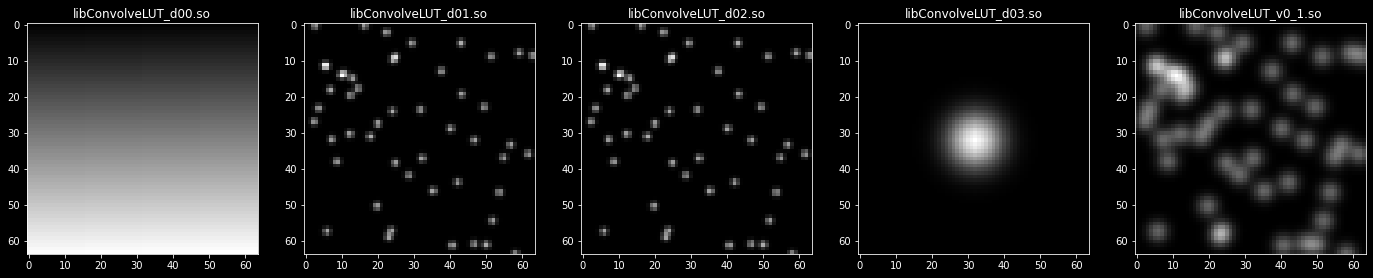

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from ctypes import CDLL, c_int, pointer, c_float
from structures import (sImage2d, sPositions2d, sPSF,
                        pImage2d, pPositions2d, pPSF)

# Cargamos las distintas bibliotecas en una lista
libraries = [CDLL(f'./bin/libConvolveLUT_d0{i:d}.so') for i in range(4)]
libraries.append(CDLL(f'./bin/libConvolveLUT_v0_1.so'))

# Definimos la aridad de la función lutConvolution2D (igual para todas)
for lib in libraries:
    lib.lutConvolution2D.argtypes = [pImage2d, pPositions2d, pPSF, c_int]

# Preparamos la imagen, la lista de posiciones y la PSF LUT
convolution_size = [64, 64]
psf_size = [25, 25]
n_sources = 100
sigma = 2.0

x_psf, y_psf = np.mgrid[0:psf_size[0], 0:psf_size[1]]
x_psf -= psf_size[0] // 2
y_psf -= psf_size[1] // 2

image = np.zeros(convolution_size[::-1], dtype=c_float)
pos = np.asarray(np.random.rand(n_sources, 2) * convolution_size, dtype=c_float)
psf = np.exp(-(x_psf**2 + y_psf**2) / sigma**2 / 2, dtype=c_float)

# Generamos las estructuras que esperan recibir las bibliotecas
c_image = sImage2d.set_data(image)
c_pos = sPositions2d.set_data(pos)
c_psf = sPSF.set_data(psf)

# Ejecutamos cada biblioteca y vemos el resultado del kernel utilizado
fig, ax = plt.subplots(1, len(libraries), figsize=(24, 8))
results = []
titles = [f'libConvolveLUT_d0{i:d}.so' for i in range(4)]
titles.append('libConvolveLUT_v0_1.so')

for i, lib in enumerate(libraries):
    lib.lutConvolution2D(c_image, c_pos, c_psf, 0)
    results.append(np.copy(image))
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(titles[i])
    # Reseteamos el resultado
    image[:] = 0.0

Verificamos que los diferentes kernels se ejecutan sin errores aparentes. Tenemos de izquierda a derecha los siguientes resultados:

1.   La identificación de cada CUDA Kernel sobre el píxel calculado
2.   Una convolución por expresión utilizando la memoria global
3.   Una convolución por expresión utilizando la memoria compartida (la diferencia en tiempos de ejecución deberá estudiarse por separado)
4.   La utilización de la Unidad de Mapeado de Texturas (TMU) para ajustar la PSF LUT al tamaño de salida.
5.   La primera convolución de tipo LUT que utiliza los 4 puntos anteriores.

Con estos cinco kernels empezaremos el análisis, pero podemos requerir otros que se desarrollarán más adelante.

#### Auxiliar: Imprimir en pantalla el STDOUT y STDERR de las bibliotecas

In [0]:
!pip install wurlitzer
from wurlitzer import pipes

with pipes() as (out, err):
    libraries[4].lutConvolution2D(c_image, c_pos, c_psf, 0)
print (out.read())

# Conclusiones

In [0]:
!ls

convolution_lut.h      libConvolveLUT_d02.so	     lutConvolutionLauncher.cu
Figura1.png	       libConvolveLUT_d03.so	     Makefile
kernel_d00.cu	       libConvolveLUT_DEBUG_d00.so   __pycache__
kernel_d01.cu	       libConvolveLUT_DEBUG_d01.so   sample_data
kernel_d02.cu	       libConvolveLUT_DEBUG_d02.so   structures.py
kernel_d03.cu	       libConvolveLUT_DEBUG_d03.so   test.c
kernel_v0_1.cu	       libConvolveLUT_DEBUG_v0_1.so  test_o.o
libConvolveLUT_d00.so  libConvolveLUT_v0_1.so	     textures.cu
libConvolveLUT_d01.so  libtest.so


En este Notebook generamos una serie de archivos que fueron subidos al [repositorio](https://github.com/alemazzeo/catmu.git) de este desarrollo:

*   **convolution_lut.h**: Archivo de cabecera para los archivos de C / CUDA que contiene las estructuras de datos que utilizamos (imagenes, lista de posiciones y PSF) junto con la declaración de todas las funciones (que se definen en archivos particulares).

*   **structures.py**: Un módulo auxiliar que definimos en Python como wrapper de las estructuras de datos.

*   **textures.cu**: Un archivo de CUDA que contiene las funciones `set_texture2d` y `free_texture` utilizadas para asignar y liberar, respectivamente, la memoria referida a la PSF de tipo LUT.

*   **lutConvolutionLauncher.cu**: El archivo que contiene la función `lutConvolution2D`, la cual sirve como punto de entrada a la biblioteca y es utilizada para ejecutar la convolución. En este Notebook dicha función será llamada desde Python mediante Ctypes, pero vale aclarar que la biblioteca dinámica generada es multiplataforma y puede ser utilizada desde otros lenguajes. El siguiente [link](https://www.mathworks.com/help/matlab/matlab_external/calling-functions-in-shared-libraries.html) por ejemplo muestra la documentación de Matlab correspondiente.

*   **kernel_d##.cu**: Cuatro archivos que ponen a prueba diferentes aspectos de la implementación. A saber:
    
    *   **d00**: *Prueba básica de paralelización*. Imprime en cada pixel de la imagen la ID del CUDA CORE asociado al mismo. Es una forma efectiva de probar las condiciones básicas: el código está bien compilado, la GPU responde, la función se llama adecuadamente, la comunicación funciona en ambos sentidos, etc.

    *   **d01**: *Prueba de lectura de posiciones desde la memoria global*. Este kernel se asemeja mucho al desarrollado para la convolución por expresión, salvo por utilizar una expresión gaussiana fija y sin parámetros controlables. 

    *   **d02**: *Prueba de lectura de posiciones desde la memoria compartida*. Este kernel transfiere la lista de posiciones desde la memoria global a la compartida y luego realiza la misma tarea. Además de poner a prueba el uso de la memoria compartida puede resultar útil para comparar tiempos entre las distintas técnicas.

    *   **d03**: *Prueba de aplicación de texturas mediante la Unidad de Mapeo de Texturas (TMU)*. Ajusta el tamaño de la PSF en el de la imagen. Esto implica en general interpolar algunos valores de la PSF (salvo para tamaños iguales o múltiplos enteros). Es una forma controlada de visualizar la interpolación realizada por la TMU.

*   **kernel_v_0_1.cu**: *Versión 0.1 para la convolución de tipo LUT*. Este kernel utiliza la memoria compartida y la aplicación de texturas para convolucionar una lista de posiciones con la PSF y generar la imagen resultante. Integra los desarrollos probados en los kernels d00 a d03.

*   **Makefile**: Un archivo para compilar con mayor facilidad las bibliotecas necesarias.

In [0]:
from google.colab import files
files.download('./convolution_lut.h')
files.download('./structures.py')
files.download('./lutConvolutionLauncher.cu')
files.download('./textures.cu')
files.download('./kernel_d00.cu')
files.download('./kernel_d01.cu')
files.download('./kernel_d02.cu')
files.download('./kernel_d03.cu')
files.download('./kernel_v0_1.cu')
files.download('./Makefile')